## Amazon Stock Price Prediction

Data Source: Yahoo Finance using `yfinance`module

**Index**

1. Data Extraction

2. Formatting data for time series

3. Feature engineering

4. ARIMA model

6. LSTM model with one feature

7. LSTM model with multiple features





In [135]:
#For first time installation. Install yfinance for yahoo finance api
#install this in the terminal if you have any issues installing it in the notebook.
#pip install yfinance
#pip install xgboost
#pip install keras
#pip install tensorflow
#pip install pmdarima

#### Import important libraries

In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns

import pmdarima as pm

# import yahoo finance and other libraries
import yfinance as yf

#for plotting
import matplotlib.pyplot as plt
%matplotlib inline

#import any one scalar for normalizing data for LSTMs
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler

#evaluation metric
from sklearn.metrics import mean_squared_error, mean_absolute_error

#for feature selection
import xgboost as xgb

#to ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Fetch Amaznon AMZN stock data and arrange
ticker = yf.Ticker('AMZN')
df = ticker.history(start='2012-01-01', end='2022-01-01')
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date']).dt.date #the Date is object type, so we will convert it to datatime
df = df.iloc[:,0:5]
df.head()

,Date,Open,High,Low,Close
0,2012-01-03,8.7945,8.9740,8.7775,8.9515
1,2012-01-04,8.9605,9.0250,8.8035,8.8755
2,2012-01-05,8.7970,8.9125,8.7025,8.8805
3,2012-01-06,8.9035,9.2325,8.8750,9.1305
4,2012-01-09,9.1380,9.2185,8.8500,8.9280


In [45]:
#some useful commands can be found here: https://analyticsindiamag.com/hands-on-guide-to-using-yfinance-api-in-python/
ticker.recommendations

,Firm,To Grade,From Grade,Action
Date,,,,
2011-12-29 12:47:00,PiperJaffray,,,main
2012-02-15 07:33:00,PiperJaffray,Overweight,,main
2012-02-16 06:17:00,Morgan Stanley,Equal-Weight,,down
2012-04-02 06:06:00,Bank oferica,Neutral,,down
2012-04-27 06:21:00,Bank oferica,Buy,,up
...,...,...,...,...
2022-11-02 17:23:28,Tigress Financial,Buy,,main
2022-11-14 11:58:40,Rosenblatt,Neutral,,main
2022-11-15 12:46:44,MoffettNathanson,Outperform,,init


In [3]:
# for ARIMA we will only use one variable 'open'
adf = df.iloc[:,[0,1]]
adf.head()

,Date,Open
0,2012-01-03,8.7945
1,2012-01-04,8.9605
2,2012-01-05,8.7970
3,2012-01-06,8.9035
4,2012-01-09,9.1380


In [9]:
print('There are {} number of records in the dataset.'.format(df.shape[0]))

There are 2517 number of records in the dataset.


In [4]:
#Object to datetime
adf['Date']= pd.to_datetime(adf['Date'])
adf.dtypes

Date    datetime64[ns]
Open           float64
dtype: object

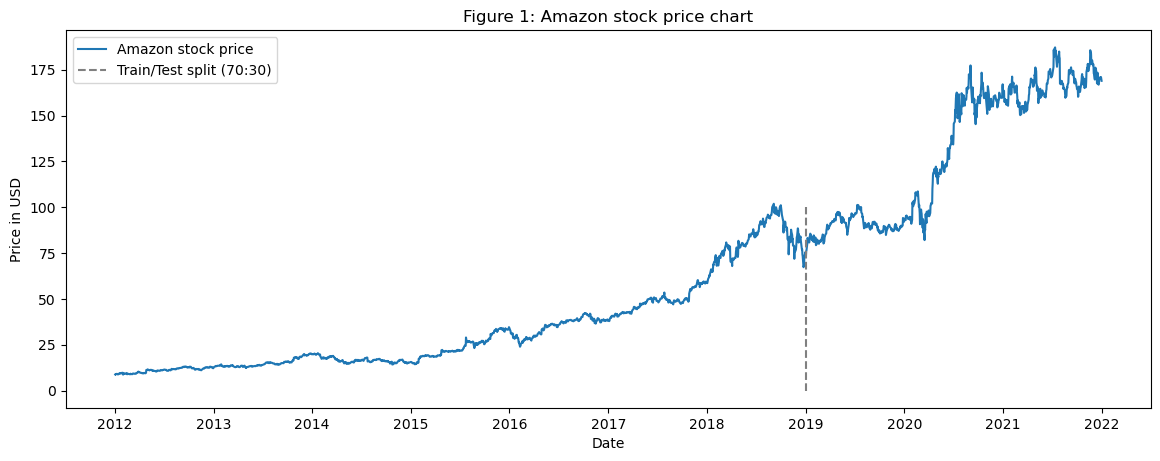

In [5]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(adf['Date'], adf['Open'], label='Amazon stock price')
plt.vlines(datetime.date(2019,1,3), 0,100, linestyles='--', colors='gray', label='Train/Test split (70:30)')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Figure 1: Amazon stock price chart')
plt.legend()
plt.show()

# **ARIMA - Auto Regressive Integrated Moving Average** 
ARIMA predictions as a feature:

ARIMA is specified by theree order parameters (p,d,q)


**AR (p) Autoregression:** An auto regressive (AR(p)) component refers to the use of past values in the regression equation for the time series.
<br/><br/>


**I (d) Integration:** uses differencing of observations (subtracting an observation with an obseervation from the previous step) in order to make the time series stationary.
<br/><br/>


**MA (q) Moving Average:** A moving average component depicts the error of the model as a combination of previous error terms. The order q represents the number of terms to be included in the model.


**p: The number of lag observations included in the model, also called the lag order.**
**d: The number of times that the raw observations are differenced, also called the degree of differencing.**
**q: The size of the moving average window, also called the order of moving average.**

Learn how to calculate p,d,q in my other repository

 
**First, we will fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.**


In [6]:
dfa = df[['Date','Open']]

Let us use Auto-ARIMA to determine the values of p,d,q

In [7]:
from pmdarima.arima import auto_arima

# we will set (p,d,q)start = 0 and (p,d,q)max = 2
arima_model = auto_arima(dfa['Open'], start_p = 0, d=0, start_q = 0, 
                          max_p = 3, max_d=2, max_q = 3,
                          seasonal = False, # there is no seasonality
                          trace = True, 
                          test = 'adf', # this will find optimal 'd'
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=50) 


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=29305.052, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=25920.496, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9487.394, Time=0.48 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=9482.600, Time=0.74 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.56 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=9481.220, Time=0.64 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.75 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.32 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=9480.775, Time=0.69 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=9485.964, Time=0.64 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=9475.137, Time=1.15 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=9482.452, Time=0.86 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=1.78 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=9476.175, Time

In [8]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = dfa['Open']
model = ARIMA(series, order=(2, 0, 3))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 2517
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -4731.137
Date:                Fri, 09 Dec 2022   AIC                           9476.274
Time:                        21:38:51   BIC                           9517.090
Sample:                             0   HQIC                          9491.087
                               - 2517                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.3592    136.011      0.458      0.647    -204.217     328.936
ar.L1          0.0215      0.007      2.874      0.004       0.007       0.036
ar.L2          0.9781      0.008    130.151      0.0

**SUMMARY OF THE ARIMA MODEL**
 
You would compare a few models with different values of p, d, q. Then, we have to look at the AIC and BIC values. Lower the values, better is the model. In this case, we used auto-arima for a quick model and came up with p=2 d=0, q=3 values.

Also, if p<0.05 those lags are considered significant. It is usually better if those values are significant to get better predictions, but it is not a hard rule.


## Prepare and Train Data with ARIMA

In [20]:
series = dfa['Open']
X = series.values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

#we predict the next value and use that prediction back in training data to predict next value
for i in range(len(test)):
    model = ARIMA(history, order=(2,0,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    new = test[i]
    history.append(new)

#df['ARIMA'] = pd.DataFrame(predictions)

In [21]:
# Evaluate the model
print('Univariate ARIMA Model MAE = ', mean_absolute_error(test, predictions))

Univariate ARIMA Model MAE =  1.8060245466202216


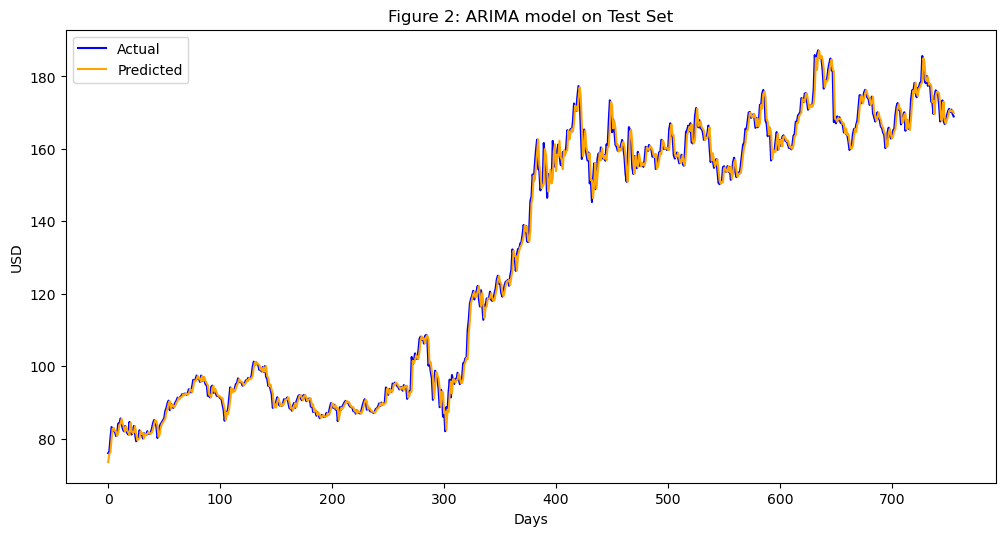

In [23]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, color='Blue', label='Actual')
plt.plot(predictions, color='Orange', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 2: ARIMA model on Test Set')
plt.legend()
plt.show()

**As we can see from Figure 2 ARIMA gives a very good approximation of the real stock price.**

# **Feature Engineering**

Let us create more technical indicators to help the model to learn more.

**1.   EMA:** An exponential moving average (EMA) is a type of moving average (MA) that places a greater weight and significance on the most recent data points.
<br/><br/>
*Formula and definition:* https://www.investopedia.com/terms/e/ema.asp


**2. Moving average ( 7 day and 21 day):** Moving averages are calculated to identify the trend direction of a stock or to determine its support and resistance levels. It is a trend-following or lagging, indicator because it is based on past prices.
<br/><br/>
*Formula and definition:* https://www.investopedia.com/terms/m/movingaverage.asp

**3. Momentum:** Momentum is the rate of acceleration of a security's price—that is, the speed at which the price is changing.
<br/><br/>
*Formula and definition:* https://www.investopedia.com/terms/m/marketmomentum.asp



In [3]:
#function to generate feature technical indicators

def technical_indicators(data): 
    
    
    # Create 7 and 21 days Moving Average
    data['MA7'] = data['Open'].rolling(window = 7).mean()
    data['MA21'] = data['Open'].rolling(window = 21).mean()
    
    #Create MACD
    data['12EMA'] = data['Open'].ewm(span=12).mean()
    data['26EMA'] = data['Open'].ewm(span=26).mean()
    data['MACD'] = (data['12EMA']-data['26EMA'])
    
    #Create Exponential moving average
    data['EMA'] = data['Open'].ewm(com=0.5).mean()
    
    #Create Momentum
    data['MOMENTUM'] = (data['Open']/100)-1
    
    return data

In [4]:
#the dataframe df has the variables required to create the technical indicators.
#create new dataframe
tdf = technical_indicators(df)
tdf.head()

,Date,Open,High,Low,Close,MA7,MA21,12EMA,26EMA,MACD,EMA,MOMENTUM
0,2012-01-03,8.7945,8.9740,8.7775,8.9515,NaN,NaN,8.794500,8.794500,0.000000,8.794500,-0.912055
1,2012-01-04,8.9605,9.0250,8.8035,8.8755,NaN,NaN,8.884417,8.880692,0.003724,8.919000,-0.910395
2,2012-01-05,8.7970,8.9125,8.7025,8.8805,NaN,NaN,8.850298,8.850622,-0.000325,8.834538,-0.912030
3,2012-01-06,8.9035,9.2325,8.8750,9.1305,NaN,NaN,8.867092,8.865405,0.001687,8.881087,-0.910965
4,2012-01-09,9.1380,9.2185,8.8500,8.9280,NaN,NaN,8.940696,8.928620,0.012076,9.053070,-0.908620


# **Feature Importance using XGBoost**

**Having so many features we have to consider whether all of them are really indicative of the direction AMZN stock will take. There are many ways to test feature importance, we will use XGBoost, because it gives one of the best results in both classification and regression problems.**

In [43]:
def features(data):
    data = data.copy()
    y = data['Open']
    X = tdf.drop(['Date','Open'], axis=1)
    
    train_samples = int(X.shape[0] * 0.70)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [44]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = features(tdf)

In [45]:
# find these hyper-parameters using grid search CV
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [46]:
#fit the model
xgbModel = regressor.fit(X_train_FI,y_train_FI,
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)],
                         verbose=False)

In [47]:
eval_result = regressor.evals_result()

In [48]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

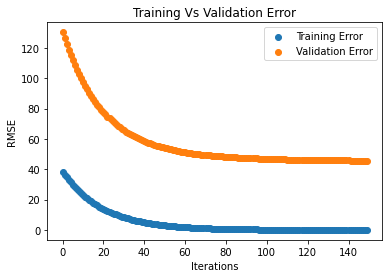

In [49]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

**The difference between validation and training error shows an underfit model. However, the way training and testing data is split, this is expected.**

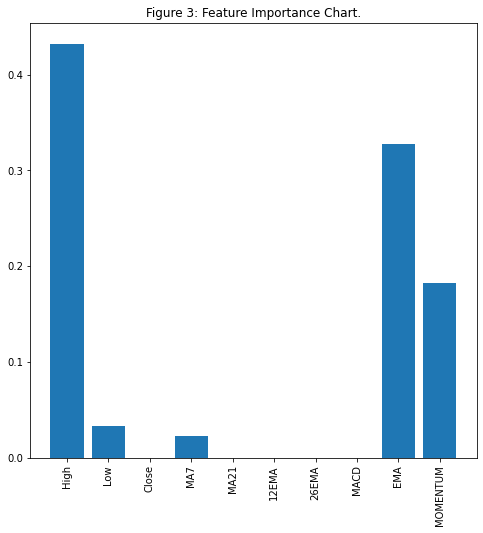

In [50]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 3: Feature Importance Chart.')
plt.show()

**High, Low, MA7, EMA, and Momentum are among the important technical indicators.** Features like high and low are bound to be close to Open prices.


# **LSTM**

**LSTM is great at predicting stock market data. We are going to try to predict the closing prices, first using 1 feature Open(It has highest correlation to closing price) and then using multiple features**

**An LSTM Network has its origin in a RNN. But it can solve the memory loss by changing the neuron architecture.**

**The new neuron has 3 gates, each with a different goal. The gates are:**

**1.Input Gate**

**2.Output Gate**

**3.Forget Gate**

**An LSTM Neuron receives input from its previous state:**

How it works: You input the data one timestep at a time to the LSTM cell. And each timestep the cell not only recieves the new input, but it recieves the last timestep's output and what is called the cell state, a vector that carries information about what happened in the past. Within the cell you have trained gates (basically small neural nets) that decide, based on the three inputs, what to forget from the past cell state, what to remember (or add) to the new state, and what to output this timestep

![alt text](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)



## **Steps for LSTM**

**1. First iteration, use LSTM with only single variable i.e. Open**

**2. Create a train, validate, and test set**

**3. Normalize data** 

**4. Seperate independant and dependant features**

**6. Train, validate data and check with test set**

**7. Make predictions**

**8. In the second iteration, use LSTM with all the important features determined by XGboost to predict Open prices**

**9. Compare the MAE of both the LSTM models to confirm whether adding more variables improves the model and predictions**



In [5]:
#Check the tdf dataframe
tdf.head()

,Date,Open,High,Low,Close,MA7,MA21,12EMA,26EMA,MACD,EMA,MOMENTUM
0,2012-01-03,8.7945,8.9740,8.7775,8.9515,NaN,NaN,8.794500,8.794500,0.000000,8.794500,-0.912055
1,2012-01-04,8.9605,9.0250,8.8035,8.8755,NaN,NaN,8.884417,8.880692,0.003724,8.919000,-0.910395
2,2012-01-05,8.7970,8.9125,8.7025,8.8805,NaN,NaN,8.850298,8.850622,-0.000325,8.834538,-0.912030
3,2012-01-06,8.9035,9.2325,8.8750,9.1305,NaN,NaN,8.867092,8.865405,0.001687,8.881087,-0.910965
4,2012-01-09,9.1380,9.2185,8.8500,8.9280,NaN,NaN,8.940696,8.928620,0.012076,9.053070,-0.908620


In [7]:
# Let us drop MA7 and MA21 since it has a lot of NaN's which is not suitalbe for a LSTM.
# we will only choose High, Low, EMA, and Momentum as choosen by XGBoost model. Open is our target variable.
lstm_df = tdf[['Open','High','Low','EMA','MOMENTUM']]
lstm_df.head(7)

,Open,High,Low,EMA,MOMENTUM
0,8.7945,8.9740,8.7775,8.794500,-0.912055
1,8.9605,9.0250,8.8035,8.919000,-0.910395
2,8.7970,8.9125,8.7025,8.834538,-0.912030
3,8.9035,9.2325,8.8750,8.881087,-0.910965
4,9.1380,9.2185,8.8500,9.053070,-0.908620
5,9.0550,9.1200,8.8550,9.054359,-0.909450
6,8.9820,9.0385,8.9095,9.006098,-0.910180


In [8]:
#shape of the dataset
lstm_df.shape

(2517, 5)

In [9]:
#import keras layers
from keras.models import Sequential
from keras.layers import Dense, LSTM

2022-12-10 16:41:31.407635: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Split dataset into train,test and validate sets**

In [10]:
#creating test, train and validate trains
train, validate, test = np.split(lstm_df, [int(.6*len(lstm_df)), int(.8*len(lstm_df))])

In [11]:
train.shape, validate.shape, test.shape

((1510, 5), (503, 5), (504, 5))

### Model with only one variable 'Open'

In [12]:
# create arrays
opentrain = train.iloc[:, 0:1].values
openval= validate.iloc[:,0:1].values
opentest = test.iloc[:,0:1].values

**Normalization**
The data is not normalized and the range for each column varies. Normalizing data helps the algorithm in converging i.e. to find local/ global minimum efficiently. I will use MinMaxScaler from Sci-kit Learn. 

In [13]:
opentrain.shape

(1510, 1)

**Note:** <br/>
1. When you scale a dataframe, if it has one variable now, it expects only one variable later during inverse_transform. If you scale a dataframe with 5 variables, the scaler expects 5 variables while inverse_transform.
So, during inverse transfrom, if you are only expecting to re-scale one variable, during training fit your scaler only on one varible and transform the entire dataframe. (i.e. use `.fit` on a column, and `.transform` on the dataframe).
<br/>
2. Fit on training data and only transform the test and val data.

In [14]:
#normalise using min-max scalar
scaler = MinMaxScaler(feature_range = (0, 1))
sopentrain = scaler.fit_transform(opentrain)
sopenval = scaler.transform(openval)
sopentest = scaler.transform(opentest)

We cannot fit the model like we normally do using ARIMA. We need to transform our data into something that looks like X and Y values.
This way it can be trained on a sequence rather than individual datapoints. 
Let us convert into n number of columns for X where we feed sequence of numbers then the final column as Y where we provide the next number in the sequence as output.
So let us convert an array (open-training) of values into a dataset matrix.

In [15]:
# use a simple for loop
def to_table(data, seq_size):
    x = []
    y = []

    for i in range(len(data)-seq_size):
        window = data[i:(i+seq_size), 0]
        x.append(window)
        y.append(data[i+seq_size, 0])
        
    return pd.DataFrame(x), pd.DataFrame(y)

In [16]:
# Re-arrange train data
traindata = to_table(sopentrain, seq_size=3)
valdata = to_table(sopenval, seq_size=3)
testdata = to_table(sopentest, seq_size=3)

In [17]:
sopentrain

array([[0.00201732],
       [0.00523727],
       [0.00206581],
       ...,
       [0.98459855],
       [0.97814893],
       [0.96811078]])

In [18]:
# the open data column has now been arranged in 4 columns, first 3 are the independant variables and the 4th is the dependant variable
traindata

(             0         1         2
 0     0.002017  0.005237  0.002066
 1     0.005237  0.002066  0.004132
 2     0.002066  0.004132  0.008680
 3     0.004132  0.008680  0.007070
 4     0.008680  0.007070  0.005654
 ...        ...       ...       ...
 1502  0.986053  0.971893  0.968188
 1503  0.971893  0.968188  0.964580
 1504  0.968188  0.964580  0.975782
 1505  0.964580  0.975782  0.984599
 1506  0.975782  0.984599  0.978149
 
 [1507 rows x 3 columns],
              0
 0     0.004132
 1     0.008680
 2     0.007070
 3     0.005654
 4     0.005441
 ...        ...
 1502  0.964580
 1503  0.975782
 1504  0.984599
 1505  0.978149
 1506  0.968111
 
 [1507 rows x 1 columns])

In [19]:
# seperate independant and dependant variables and typecast it to array type since it is a requirement for LSTM in keras
x_train = np.array(traindata[0])
y_train=np.array(traindata[1])
x_val = np.array(valdata[0])
y_val = np.array(valdata[1])
x_test = np.array(testdata[0])
y_test = np.array(testdata[1])

In [20]:
x_train.shape, y_train.shape

((1507, 3), (1507, 1))

In [21]:
y_train

array([[0.00413162],
       [0.00868029],
       [0.00707033],
       ...,
       [0.98459855],
       [0.97814893],
       [0.96811078]])

**Convert feature set and label set into arrays and shape feature set into a 3D input that LSTM network demands**

In [22]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
train_x = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], 1)) #[samples, timesteps, features]
val_x = np.reshape(x_val, (x_val.shape[0],x_val.shape[1], 1)) #[samples, timesteps, features]

In [23]:
#use this  as input shape in LSTM layer
train_x.shape[1], train_x.shape[2]

(3, 1)

In [25]:
#instantiate and fit the model. You can use stacked LSTM's. 
# if you add another layer, use return_sequence=TRUE in the first layer, so that the sequence is returned to layer 2.

#model.reset_states() #this is only if you run the model again
model = Sequential()
model.add(LSTM(15, input_shape=(3, 1), activation='relu')) # 3 is the timesteps, 1 is the no. of features
#model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
print(model.summary())

# fit the model
#del history #this is only if you run the model again
#set verbose=False if you don't want to see the output
history = model.fit(train_x, y_train, epochs = 100, batch_size = 32,validation_data = (val_x, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15)                1020      
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________


2022-12-10 16:42:22.339840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


None
Epoch 1/100
48/48 [==============================] - 2s 12ms/step - loss: 0.1149 - mean_absolute_error: 0.2453 - val_loss: 1.3596 - val_mean_absolute_error: 1.1582
Epoch 2/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0488 - mean_absolute_error: 0.1522 - val_loss: 0.4923 - val_mean_absolute_error: 0.6963
Epoch 3/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0074 - mean_absolute_error: 0.0545 - val_loss: 0.0213 - val_mean_absolute_error: 0.1410
Epoch 4/100
48/48 [==============================] - 0s 6ms/step - loss: 2.8632e-04 - mean_absolute_error: 0.0113 - val_loss: 0.0036 - val_mean_absolute_error: 0.0509
Epoch 5/100
48/48 [==============================] - 0s 5ms/step - loss: 1.6120e-04 - mean_absolute_error: 0.0088 - val_loss: 0.0023 - val_mean_absolute_error: 0.0378
Epoch 6/100
48/48 [==============================] - 0s 5ms/step - loss: 1.4079e-04 - mean_absolute_error: 0.0080 - val_loss: 0.0021 - val_mean_absolute_error: 0.0351
Epoc

Epoch 50/100
48/48 [==============================] - 0s 5ms/step - loss: 1.1903e-04 - mean_absolute_error: 0.0072 - val_loss: 0.0055 - val_mean_absolute_error: 0.0610
Epoch 51/100
48/48 [==============================] - 0s 5ms/step - loss: 1.2178e-04 - mean_absolute_error: 0.0072 - val_loss: 0.0041 - val_mean_absolute_error: 0.0517
Epoch 52/100
48/48 [==============================] - 0s 5ms/step - loss: 1.1948e-04 - mean_absolute_error: 0.0073 - val_loss: 0.0065 - val_mean_absolute_error: 0.0678
Epoch 53/100
48/48 [==============================] - 0s 5ms/step - loss: 1.2736e-04 - mean_absolute_error: 0.0075 - val_loss: 0.0043 - val_mean_absolute_error: 0.0530
Epoch 54/100
48/48 [==============================] - 0s 5ms/step - loss: 1.2864e-04 - mean_absolute_error: 0.0076 - val_loss: 0.0055 - val_mean_absolute_error: 0.0614
Epoch 55/100
48/48 [==============================] - 0s 5ms/step - loss: 1.1577e-04 - mean_absolute_error: 0.0070 - val_loss: 0.0052 - val_mean_absolute_error:

Epoch 99/100
48/48 [==============================] - 0s 6ms/step - loss: 1.2591e-04 - mean_absolute_error: 0.0077 - val_loss: 0.0050 - val_mean_absolute_error: 0.0580
Epoch 100/100
48/48 [==============================] - 0s 5ms/step - loss: 1.2045e-04 - mean_absolute_error: 0.0072 - val_loss: 0.0067 - val_mean_absolute_error: 0.0685


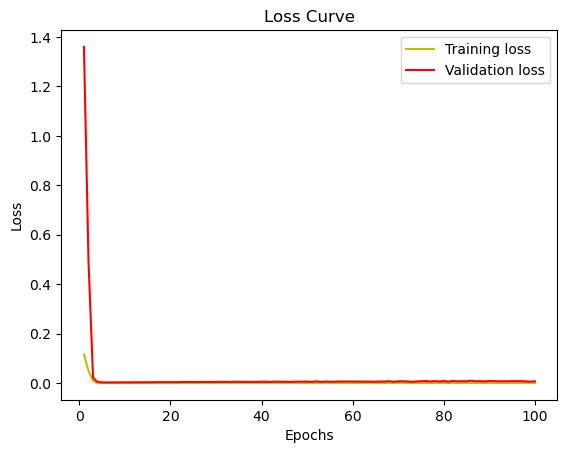

In [26]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
x_train.shape, x_val.shape

((1507, 3), (500, 3))

**MAE: This means that the average difference between input and ouput for all 1507 datapoints is 0.007. Which is good.
The value is for the days here so 1507 length of train set will be denominator. Which means, the difference between actual and prediced values is small that such a large denominator dividing the difference puts MAE in rage of 10^-3 i.e. 0.00xxx**

**For the validation set, we have MAE=0.08. Let's make predictions and check how the model performs on the test set**

### Making Predictions on Test set

In [28]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
test_x = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], 1)) #[samples, timesteps, features]

In [29]:
# make predictions
testpredict = model.predict(test_x)

16/16 [==============================] - 0s 3ms/step


In [30]:
test_x.shape, testpredict.shape

((501, 3, 1), (501, 1))

In [31]:
# rescale all the observations
testpredict = scaler.inverse_transform(testpredict)
x_train1 = scaler.inverse_transform(x_train)
y_train1 = scaler.inverse_transform(y_train)
x_test1 = scaler.inverse_transform(x_test)
y_test1 = scaler.inverse_transform(y_test)

In [32]:
y_test1

array([[ 94.90200043],
       [ 95.49449921],
       [ 95.26850128],
       [ 94.56549835],
       [ 94.29399872],
       [ 93.61250305],
       [ 94.14949799],
       [ 94.29450226],
       [ 93.25      ],
       [ 94.80449677],
       [ 94.25550079],
       [ 94.5684967 ],
       [ 91.        ],
       [ 92.02500153],
       [ 93.19999695],
       [ 92.90000153],
       [102.57350159],
       [100.52999878],
       [101.4940033 ],
       [103.5510025 ],
       [102.0510025 ],
       [102.09950256],
       [104.25050354],
       [107.54499817],
       [108.16000366],
       [107.24949646],
       [107.78399658],
       [106.25099945],
       [108.38999939],
       [108.65350342],
       [107.10749817],
       [100.15899658],
       [101.32099915],
       [ 98.51399994],
       [ 96.71900177],
       [ 90.73149872],
       [ 95.32450104],
       [ 98.76850128],
       [ 97.32849884],
       [ 96.65000153],
       [ 93.75      ],
       [ 88.69300079],
       [ 93.54399872],
       [ 92

In [33]:
# Evaluate the model
print('Single variable LSTM MAE = ', mean_absolute_error(y_test1, testpredict))

Single variable LSTM MAE =  40.629712651113785


**Plot the prediction model for the number of test days and train days**

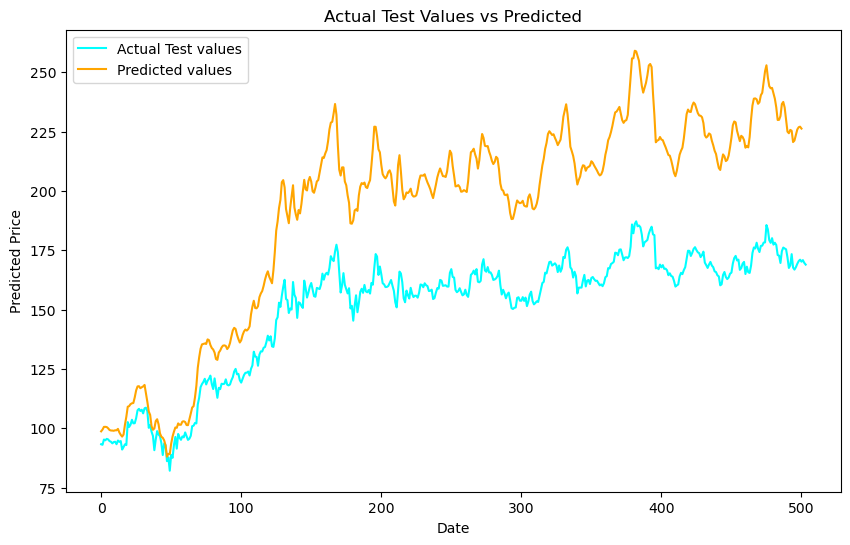

In [34]:
plt.figure(figsize=(10,6))
plt.plot(opentest, color='Cyan', label='Actual Test values')
plt.plot(testpredict , color='Orange', label='Predicted values')
plt.title('Actual Test Values vs Predicted')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()


### Obviously, one variable in itself is not generating good results.

### **Using more than one feature**


**We will try LSTM with the best 5 features from the result of the xgboost deature selection. We can than compare the MAE's to check whether more features improves the model.**

In [35]:
lstm_df.head()

,Open,High,Low,EMA,MOMENTUM
0,8.7945,8.9740,8.7775,8.794500,-0.912055
1,8.9605,9.0250,8.8035,8.919000,-0.910395
2,8.7970,8.9125,8.7025,8.834538,-0.912030
3,8.9035,9.2325,8.8750,8.881087,-0.910965
4,9.1380,9.2185,8.8500,9.053070,-0.908620


In [36]:
#create a copy
data = lstm_df.copy()
data.head()

,Open,High,Low,EMA,MOMENTUM
0,8.7945,8.9740,8.7775,8.794500,-0.912055
1,8.9605,9.0250,8.8035,8.919000,-0.910395
2,8.7970,8.9125,8.7025,8.834538,-0.912030
3,8.9035,9.2325,8.8750,8.881087,-0.910965
4,9.1380,9.2185,8.8500,9.053070,-0.908620


### Split dataset into train, test and validate sets

In [37]:
#creating test, train and validate trains
train, val, test = np.split(data, [int(.6*len(data)), int(.8*len(data))])

In [38]:
train.shape, val.shape, test.shape

((1510, 5), (503, 5), (504, 5))

## Let' see first what rearranging does

In [87]:
data_array = np.array(data)

In [88]:
len(data_array)

2517

In [89]:
# For data
X = []
Y = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 3

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(data_array) - n_future +1):
    X.append(data_array[i - n_past:i, 0:data_array.shape[1]])
    Y.append(data_array[i + n_future - 1:i + n_future, 0])

In [90]:
data.head(12)

,Open,High,Low,EMA,MOMENTUM
0,8.7945,8.9740,8.7775,8.794500,-0.912055
1,8.9605,9.0250,8.8035,8.919000,-0.910395
2,8.7970,8.9125,8.7025,8.834538,-0.912030
3,8.9035,9.2325,8.8750,8.881087,-0.910965
4,9.1380,9.2185,8.8500,9.053070,-0.908620
5,9.0550,9.1200,8.8550,9.054359,-0.909450
6,8.9820,9.0385,8.9095,9.006098,-0.910180
7,8.9710,8.9745,8.7875,8.982695,-0.910290
8,8.7905,8.9400,8.6750,8.854558,-0.912095
9,9.0075,9.1650,8.9255,8.956521,-0.909925


In [91]:
X

[array([[ 8.79450035,  8.97399998,  8.77750015,  8.79450035, -0.912055  ],
        [ 8.96049976,  9.02499962,  8.80350018,  8.91899991, -0.910395  ],
        [ 8.79699993,  8.91250038,  8.70250034,  8.83453839, -0.91203   ]]),
 array([[ 8.96049976,  9.02499962,  8.80350018,  8.91899991, -0.910395  ],
        [ 8.79699993,  8.91250038,  8.70250034,  8.83453839, -0.91203   ],
        [ 8.9034996 ,  9.23250008,  8.875     ,  8.88108721, -0.910965  ]]),
 array([[ 8.79699993,  8.91250038,  8.70250034,  8.83453839, -0.91203   ],
        [ 8.9034996 ,  9.23250008,  8.875     ,  8.88108721, -0.910965  ],
        [ 9.13799953,  9.21850014,  8.85000038,  9.05306984, -0.90862   ]]),
 array([[ 8.9034996 ,  9.23250008,  8.875     ,  8.88108721, -0.910965  ],
        [ 9.13799953,  9.21850014,  8.85000038,  9.05306984, -0.90862   ],
        [ 9.05500031,  9.11999989,  8.85499954,  9.05435858, -0.90945   ]]),
 array([[ 9.13799953,  9.21850014,  8.85000038,  9.05306984, -0.90862   ],
        [ 9.05500

In [92]:
Y

[array([8.9034996]),
 array([9.13799953]),
 array([9.05500031]),
 array([8.98200035]),
 array([8.97099972]),
 array([8.79049969]),
 array([9.00749969]),
 array([9.09700012]),
 array([9.54399967]),
 array([9.53549957]),
 array([9.53950024]),
 array([9.25]),
 array([9.3494997]),
 array([9.46500015]),
 array([9.65450001]),
 array([9.68400002]),
 array([9.69999981]),
 array([8.69050026]),
 array([8.98250008]),
 array([9.14150047]),
 array([9.31400013]),
 array([9.13249969]),
 array([9.24750042]),
 array([9.22500038]),
 array([9.17099953]),
 array([9.35849953]),
 array([9.5539999]),
 array([9.56449986]),
 array([8.88949966]),
 array([9.00450039]),
 array([9.13249969]),
 array([9.09749985]),
 array([8.98200035]),
 array([8.98499966]),
 array([8.87699986]),
 array([8.94499969]),
 array([9.19449997]),
 array([8.99450016]),
 array([8.97399998]),
 array([8.94999981]),
 array([8.93400002]),
 array([9.13249969]),
 array([9.20849991]),
 array([9.33950043]),
 array([9.20650005]),
 array([9.1960001])

Open variable values are in the Y column. Which is what we want.

### Normalize the data

In [40]:
#normalise using min-max scalar
scaler = MinMaxScaler(feature_range = (0, 1))
strain = scaler.fit_transform(train)
sval = scaler.transform(val)
stest = scaler.transform(test)

In [41]:
# For train
Xtrain = []
Ytrain = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 3

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(strain) - n_future +1):
    Xtrain.append(strain[i - n_past:i, 0:train.shape[1]])
    Ytrain.append(strain[i + n_future - 1:i + n_future, 0])


In [42]:
# For val
Xval = []
Yval = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 3

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(sval) - n_future +1):
    Xval.append(sval[i - n_past:i, 0:val.shape[1]])
    Yval.append(sval[i + n_future - 1:i + n_future, 0])

In [43]:
# For test
Xtest = []
Ytest = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 3

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(stest) - n_future +1):
    Xtest.append(stest[i - n_past:i, 0:test.shape[1]])
    Ytest.append(stest[i + n_future - 1:i + n_future, 0])

In [44]:
# change type to array
Xtrain, Ytrain = np.array(Xtrain), np.array(Ytrain)
Xval, Yval = np.array(Xval), np.array(Yval)
Xtest, Ytest = np.array(Xtest), np.array(Ytest)

Xtrain.shape,Ytrain.shape


((1507, 3, 5), (1507, 1))

Learn how to onvert a time series to supervised learning: <br/>
https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [45]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
train_X = np.reshape(Xtrain, (Xtrain.shape[0],Xtrain.shape[1], 5)) #[samples, timesteps, features]
val_X = np.reshape(Xval, (Xval.shape[0],Xval.shape[1], 5))

### LSTM Model

In [46]:
#instantiate and fit the model

model.reset_states() # this is to clear the model from 1st lstm
model = Sequential()
model.add(LSTM(15, input_shape=(3, 5), activation='relu')) # 3 is the timesteps, 1 is the one from the reshape 
#model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
print(model.summary())

# fit the model
del history # this is to clear the history from 1st lstm
#set verbose=False if you don't want to see the output
history = model.fit(train_X, Ytrain, epochs = 100, batch_size = 32,validation_data = (val_X, Yval))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 15)                1260      
                                                                 
 dense_1 (Dense)             (None, 1)                 16        
                                                                 
Total params: 1,276
Trainable params: 1,276
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
48/48 [==============================] - 3s 18ms/step - loss: 0.0210 - mean_absolute_error: 0.0893 - val_loss: 0.0568 - val_mean_absolute_error: 0.2265
Epoch 2/100
48/48 [==============================] - 0s 6ms/step - loss: 4.4469e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0447 - val_mean_absolute_error: 0.1984
Epoch 3/100
48/48 [==============================] - 0s 6ms/step - loss: 1.5264e-04 - mean_absolute_error: 0.008

Epoch 46/100
48/48 [==============================] - 0s 6ms/step - loss: 9.5865e-05 - mean_absolute_error: 0.0063 - val_loss: 0.0013 - val_mean_absolute_error: 0.0256
Epoch 47/100
48/48 [==============================] - 0s 5ms/step - loss: 9.0579e-05 - mean_absolute_error: 0.0060 - val_loss: 0.0013 - val_mean_absolute_error: 0.0268
Epoch 48/100
48/48 [==============================] - 0s 5ms/step - loss: 9.1692e-05 - mean_absolute_error: 0.0061 - val_loss: 0.0013 - val_mean_absolute_error: 0.0265
Epoch 49/100
48/48 [==============================] - 0s 5ms/step - loss: 9.0891e-05 - mean_absolute_error: 0.0060 - val_loss: 0.0013 - val_mean_absolute_error: 0.0260
Epoch 50/100
48/48 [==============================] - 0s 5ms/step - loss: 9.1978e-05 - mean_absolute_error: 0.0062 - val_loss: 0.0012 - val_mean_absolute_error: 0.0256
Epoch 51/100
48/48 [==============================] - 0s 5ms/step - loss: 8.9603e-05 - mean_absolute_error: 0.0061 - val_loss: 0.0014 - val_mean_absolute_error:

Epoch 95/100
48/48 [==============================] - 0s 5ms/step - loss: 7.2966e-05 - mean_absolute_error: 0.0054 - val_loss: 0.0012 - val_mean_absolute_error: 0.0253
Epoch 96/100
48/48 [==============================] - 0s 5ms/step - loss: 9.4573e-05 - mean_absolute_error: 0.0064 - val_loss: 0.0025 - val_mean_absolute_error: 0.0426
Epoch 97/100
48/48 [==============================] - 0s 5ms/step - loss: 7.5701e-05 - mean_absolute_error: 0.0055 - val_loss: 0.0019 - val_mean_absolute_error: 0.0350
Epoch 98/100
48/48 [==============================] - 0s 5ms/step - loss: 7.3970e-05 - mean_absolute_error: 0.0054 - val_loss: 0.0027 - val_mean_absolute_error: 0.0439
Epoch 99/100
48/48 [==============================] - 0s 5ms/step - loss: 7.2568e-05 - mean_absolute_error: 0.0053 - val_loss: 0.0032 - val_mean_absolute_error: 0.0492
Epoch 100/100
48/48 [==============================] - 0s 5ms/step - loss: 9.3121e-05 - mean_absolute_error: 0.0065 - val_loss: 0.0021 - val_mean_absolute_error

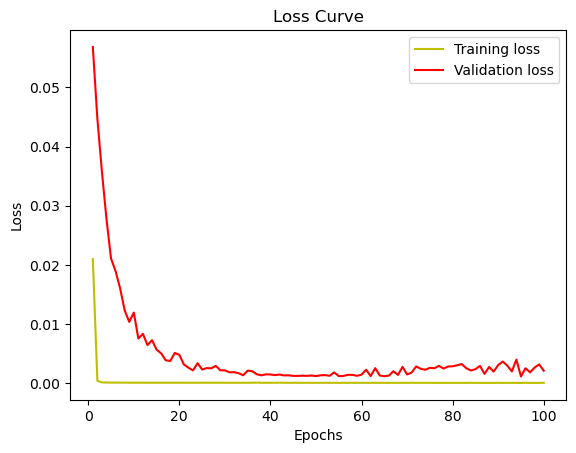

In [49]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**MAE: This means that the average difference between input and ouput for all 1507 datapoints is 0.005. Which is good.
The value is for the days here so 1507 length of train set will be denominator. Which means, the difference between actual and prediced values is small that such a large denominator dividing the difference puts MAE in rage of 10^-3 i.e. 0.00xxx**

**Same for the validation set. We will now make predictions and check how the model performs on the test set**

### Making Predictions on Test set

In [50]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
test_X = np.reshape(Xtest, (Xtest.shape[0],Xtest.shape[1], 5)) #[samples, timesteps, features]

In [51]:
# make predictions
testpredict = model.predict(test_X)

16/16 [==============================] - 0s 2ms/step


In [52]:
test_X.shape, testpredict.shape

((501, 3, 5), (501, 1))

In [59]:
testpredict.shape

(501, 1)

Remember, we did scalar transform on 5 variables. So to do inverse transform the scalar expects 5 variables. But since we only have one predicted variable, we will make duplicates of that column 5 times and use inverse transform.

In [57]:
# rescale all the observations
test_prediction_copies = np.repeat(testpredict, 5, axis=-1)
testpred = scaler.inverse_transform(test_prediction_copies)[:,0]
testpred

array([ 91.87209 ,  92.043   ,  92.46551 ,  92.293144,  92.147575,
        91.68513 ,  91.32426 ,  91.39775 ,  91.31606 ,  91.33074 ,
        91.76401 ,  91.60218 ,  91.54697 ,  90.2416  ,  90.24926 ,
        90.31953 ,  90.54619 ,  94.56959 ,  95.682434,  97.5692  ,
        98.03712 ,  97.94219 ,  98.44623 ,  99.338646, 101.010445,
       101.87729 , 102.0802  , 101.957825, 101.63183 , 102.274994,
       102.174934, 101.713425,  98.96396 ,  97.87476 ,  96.30795 ,
        94.83523 ,  91.409065,  92.66752 ,  93.33574 ,  94.330154,
        94.30376 ,  92.77454 ,  89.267746,  90.58193 ,  89.963646,
        85.80044 ,  86.71632 ,  83.13664 ,  86.21614 ,  86.68237 ,
        90.00115 ,  91.1795  ,  91.3119  ,  93.26526 ,  92.8373  ,
        93.3339  ,  93.34788 ,  93.60402 ,  94.45303 ,  93.77461 ,
        93.374054,  92.94033 ,  93.73641 ,  95.50474 ,  96.544   ,
        97.43165 ,  98.73376 , 102.43573 , 104.9888  , 108.54342 ,
       109.26547 , 110.76703 , 110.35333 , 110.33745 , 110.835

In [61]:
test['Open']

2013     93.224998
2014     93.000000
2015     95.224998
2016     94.902000
2017     95.494499
           ...    
2512    171.037003
2513    170.182495
2514    170.839996
2515    169.699997
2516    168.955994
Name: Open, Length: 504, dtype: float64

**Plot the prediction model for the number of test days and train days**

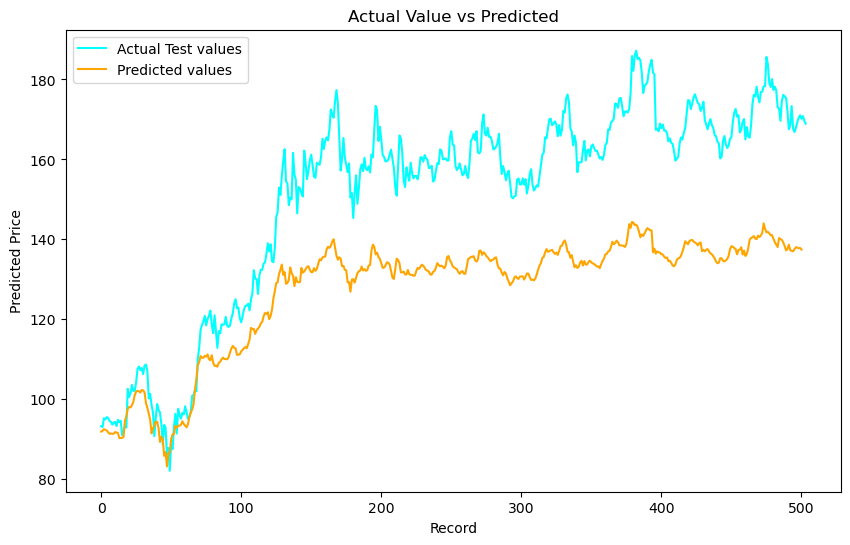

In [63]:
plt.figure(figsize=(10,6))
plt.plot(opentest, color='Cyan', label='Actual Test values')
plt.plot(testpred , color='Orange', label='Predicted values')
plt.title('Actual Value vs Predicted')
plt.xlabel('Record')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()


In [65]:
# Evaluate the model
print('Multi variable LSTM MAE = ', mean_absolute_error(Ytest, testpred))

Multi variable LSTM MAE =  124.40947550327188


**The mean absolute error is higher than the past model with one feature.**

**You can try improving the model by tuning the hyperparameters, adding more variables**